# Package installation and module import

In [47]:
# YouTube API packages
# pip install --upgrade google-api-python-client
# pip install --upgrade google-auth-oauthlib google-auth-httplib2

In [48]:
# Database packages
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON
import isodate

# Data viz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
sns.set(style="darkgrid", color_codes=True)

# Env with api_key and channel_ids
from dotenv import load_dotenv
import os

# Natural Language Processing (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud, STOPWORDS

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>


# Data collection and preparation

### Channel stats

In [49]:
api_key = os.getenv('api_key')

# List with YouTube channels: 
channel_ids = ['UCkjjH0hsvaeRIuwGlM9oSvg', # Mis Pastelitos
               'UCEwl20VxZ3AwOgiKMZtI1GQ', # La Capital
               'UCVZsY1CF9VwLTKgs9YLQkXw', # Jauja Cocina Mexicana
               'UCuGn3ioftOo6jvHE1YK4Bfw', # El Guzzi
               'UCp5tDWMJWnzmNlwurP-pDLw', # Marisolpink
               'UCJjyyWFwUIOfKhb35WgCqVg', # De mi Rancho a Tu Cocina
               'UC96WGEYgakZRuej-YI0X1Iw', # Jennifer Salas Postres
               'UCnGnDstLltFo-JpmJF1U-YQ', # RAUL BARTENDER
               'UCUAQgUTv4-OiAClB1jYTPnA' # La Ruta de la Garnacha
               ]

In [50]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

request = youtube.channels().list(
   part="snippet,contentDetails,statistics",
   id=','.join(channel_ids)
)
response = request.execute()


JSON(response)

<IPython.core.display.JSON object>

In [51]:
def get_channel_stats(youtube, channel_ids):
    """
    Get channel statistics: title, subscriber count, view count, video count, upload playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    channels_ids: list of channel IDs
    
    Returns:
    Dataframe containing the channel statistics for all channels in the provided list: title, subscriber count, view count, video count, upload playlist
    
    """
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)

In [52]:
channel_stats = get_channel_stats(youtube, channel_ids)

channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,La Ruta de la Garnacha,2100000,458083961,1177,UUUAQgUTv4-OiAClB1jYTPnA
1,RAUL BARTENDER,2180000,868524195,675,UUnGnDstLltFo-JpmJF1U-YQ
2,De mi Rancho a Tu Cocina,4320000,463999715,452,UUJjyyWFwUIOfKhb35WgCqVg
3,Jauja Cocina Mexicana,8220000,1443971196,764,UUVZsY1CF9VwLTKgs9YLQkXw
4,Mis Pastelitos,14900000,2906420185,618,UUkjjH0hsvaeRIuwGlM9oSvg
5,Marisolpink,6080000,727838936,599,UUp5tDWMJWnzmNlwurP-pDLw
6,El Guzii,6600000,1025135204,529,UUuGn3ioftOo6jvHE1YK4Bfw
7,Jennifer Salas Postres,3550000,386054038,951,UU96WGEYgakZRuej-YI0X1Iw
8,La Capital,9420000,1997527094,337,UUEwl20VxZ3AwOgiKMZtI1GQ


In [53]:
# Rename columns (CamelCase to snake_case)
channel_column_name_mapping = {
   'channelName': 'channel_name',
   'totalVideos': 'total_videos',
   'playlistId': 'playlist_id',
}

channel_stats = channel_stats.rename(columns= channel_column_name_mapping)

channel_stats

,channel_name,subscribers,views,total_videos,playlist_id
0,La Ruta de la Garnacha,2100000,458083961,1177,UUUAQgUTv4-OiAClB1jYTPnA
1,RAUL BARTENDER,2180000,868524195,675,UUnGnDstLltFo-JpmJF1U-YQ
2,De mi Rancho a Tu Cocina,4320000,463999715,452,UUJjyyWFwUIOfKhb35WgCqVg
3,Jauja Cocina Mexicana,8220000,1443971196,764,UUVZsY1CF9VwLTKgs9YLQkXw
4,Mis Pastelitos,14900000,2906420185,618,UUkjjH0hsvaeRIuwGlM9oSvg
5,Marisolpink,6080000,727838936,599,UUp5tDWMJWnzmNlwurP-pDLw
6,El Guzii,6600000,1025135204,529,UUuGn3ioftOo6jvHE1YK4Bfw
7,Jennifer Salas Postres,3550000,386054038,951,UU96WGEYgakZRuej-YI0X1Iw
8,La Capital,9420000,1997527094,337,UUEwl20VxZ3AwOgiKMZtI1GQ


In [54]:
channel_stats.dtypes

channel_name    object
subscribers     object
views           object
total_videos    object
playlist_id     object
dtype: object

In [55]:
# Convert count columns to numeric
channel_numeric_cols = ['subscribers', 'views', 'total_videos']
channel_stats[channel_numeric_cols] = channel_stats[channel_numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

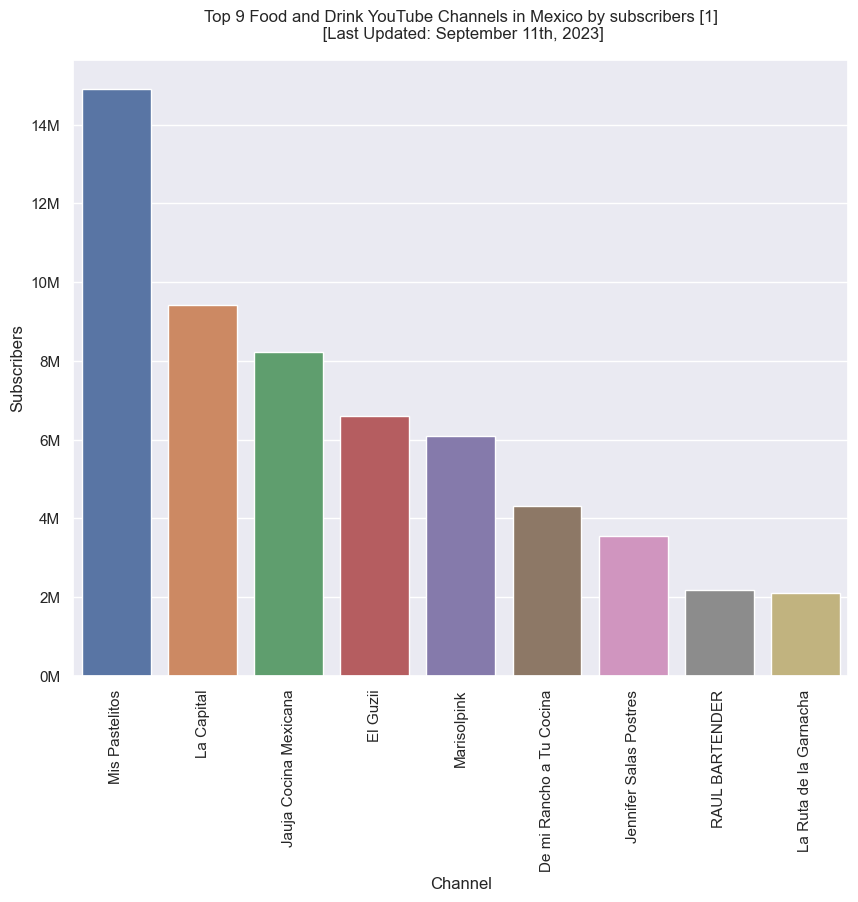

In [56]:
# Subscribers graph plot
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x='channel_name', y='subscribers', data=channel_stats.sort_values('subscribers', ascending=False))

plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1_000_000) + 'M'))

ax.set_xlabel('Channel')
ax.set_ylabel('Subscribers')
plt.title("Top 9 Food and Drink YouTube Channels in Mexico by subscribers [1]\n [Last Updated: September 11th, 2023]", pad= 15);

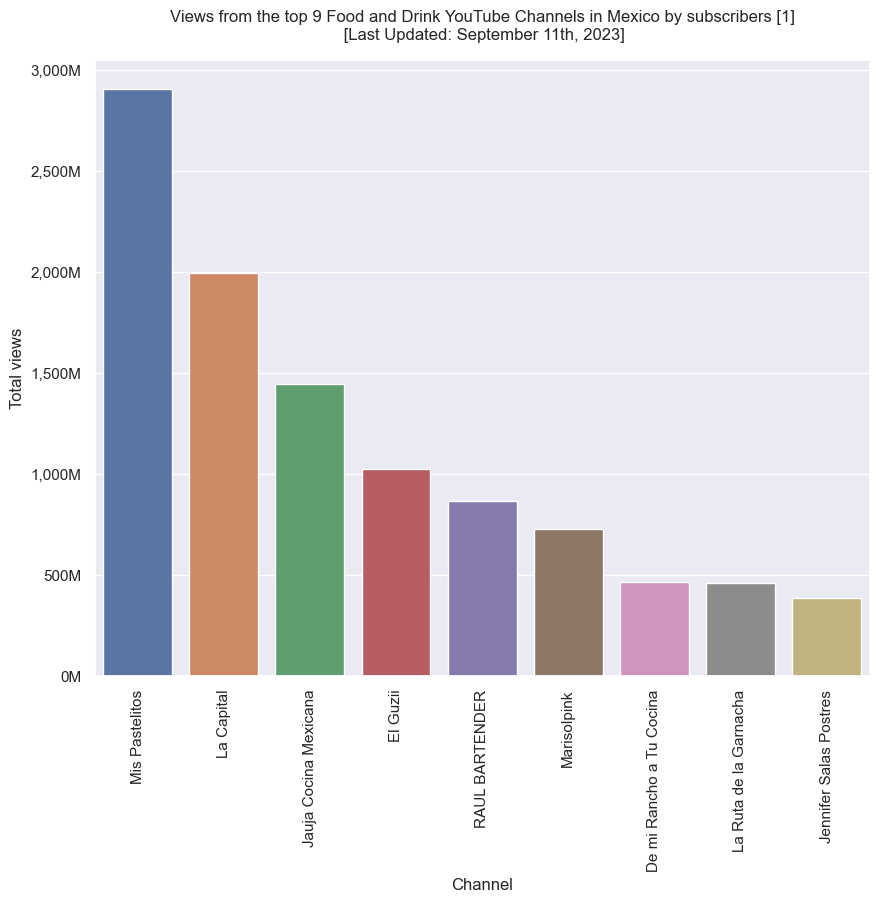

In [57]:
ax = sns.barplot(x='channel_name', y='views', data=channel_stats.sort_values('views', ascending=False))

plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1_000_000) + 'M'))

ax.set_xlabel('Channel')
ax.set_ylabel('Total views')
plt.title("Views from the top 9 Food and Drink YouTube Channels in Mexico by subscribers [1]\n [Last Updated: September 11th, 2023]", pad= 15);

### Video stats

In [58]:
def get_video_ids(youtube, playlist_id):
    """
    Get list of video IDs of all videos in the given playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel
    
    Returns:
    List of video IDs of all videos in the playlist
    
    """
    
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

In [59]:
def get_video_details(youtube, video_ids):
    """
    Get video statistics of all videos with given IDs
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt'
        'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
        'duration', 'definition', 'caption'
    """
        
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)

In [60]:
# Create a dataframe with video statistics from all channels

video_df = pd.DataFrame()

for c in channel_stats['channel_name'].unique():
    print("Getting video information from channel: " + c)
    playlist_id = channel_stats.loc[channel_stats['channel_name']== c, 'playlist_id'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    
    # get video data
    video_data = get_video_details(youtube, video_ids)
    
    video_df = video_df.append(video_data, ignore_index=True)

Getting video information from channel: La Ruta de la Garnacha
Getting video information from channel: RAUL BARTENDER
Getting video information from channel: De mi Rancho a Tu Cocina
Getting video information from channel: Jauja Cocina Mexicana
Getting video information from channel: Mis Pastelitos
Getting video information from channel: Marisolpink
Getting video information from channel: El Guzii
Getting video information from channel: Jennifer Salas Postres
Getting video information from channel: La Capital


In [61]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,U_u_duq11QI,La Ruta de la Garnacha,Increible y jugoso LECHÓN HORNEADO en la Narvarte,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-12T14:00:29Z,7566,595,None,6,PT58S,hd,false
1,i3pGylK847s,La Ruta de la Garnacha,¿TORTAS ó TACOS? 24HRS de SABOR en Ferrería,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-11T18:33:45Z,209993,5444,None,209,PT15M34S,hd,false
2,kOLRh9e9XiM,La Ruta de la Garnacha,Las FAMOSAS y AUTÉNTICAS Flautas de La Romero ...,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-10T16:00:36Z,13241,894,None,13,PT1M,hd,false
3,aPkvpghF2tY,La Ruta de la Garnacha,Super TACOS de CARNITAS con mucho sabor a Mich...,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-09T16:30:01Z,19216,1246,None,9,PT58S,hd,false
4,jbyl5Mq2sk0,La Ruta de la Garnacha,FLAUTAS SÚPER rellenas de CARNE,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-08T14:00:25Z,11086,806,None,12,PT51S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6019,qQ1P2JPf_IU,La Capital,Queso fundido con Chorizo | Botana Fácil | La ...,Gran opción para botanear antes de una carne a...,"[queso fundido, queso gratinado, con chorizo, ...",2016-08-27T16:30:01Z,3778484,155069,None,3020,PT7M9S,hd,false
6020,VcciYKH8hAM,La Capital,Verdaderos Camarones A LA DIABLA | La Capital,Después de varias malas experiencias en restau...,"[camarones a la diabla, camarones, mexican sea...",2016-08-21T16:30:00Z,3851719,122541,None,2705,PT5M56S,hd,false
6021,0uDlaSepHL0,La Capital,Chilaquiles Verdes con Huevo | La Capital,El mejor desayuno y mi favorito siempre! Chila...,"[chilaquiles, chilaquiles verdes, chile habane...",2016-08-14T16:45:04Z,3881171,122292,None,5156,PT9M55S,hd,false
6022,TtaybghWcow,La Capital,Pechuga Rellena de Camaron *ENVUELTA EN TOCINO...,Video de Aguachiles: https://goo.gl/nsRHPd\n\n...,"[pechuga de pollo, pechuga rellena, camarones,...",2016-08-10T14:51:50Z,1759061,70956,None,2708,PT12M36S,hd,false


In [62]:
# Rename columns (CamelCase to snake_case)
video_column_name_mapping = {
   'channelTitle': 'channel_title',
   'publishedAt': 'published_at',
   'viewCount': 'view_count',
   'likeCount': 'like_count',
   'favouriteCount': 'favorite_count',
   'commentCount': 'comment_count',
}

video_df = video_df.rename(columns= video_column_name_mapping)

video_df.head()

,video_id,channel_title,title,description,tags,published_at,view_count,like_count,favorite_count,comment_count,duration,definition,caption
0,U_u_duq11QI,La Ruta de la Garnacha,Increible y jugoso LECHÓN HORNEADO en la Narvarte,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-12T14:00:29Z,7566,595,None,6,PT58S,hd,false
1,i3pGylK847s,La Ruta de la Garnacha,¿TORTAS ó TACOS? 24HRS de SABOR en Ferrería,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-11T18:33:45Z,209993,5444,None,209,PT15M34S,hd,false
2,kOLRh9e9XiM,La Ruta de la Garnacha,Las FAMOSAS y AUTÉNTICAS Flautas de La Romero ...,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-10T16:00:36Z,13241,894,None,13,PT1M,hd,false
3,aPkvpghF2tY,La Ruta de la Garnacha,Super TACOS de CARNITAS con mucho sabor a Mich...,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-09T16:30:01Z,19216,1246,None,9,PT58S,hd,false
4,jbyl5Mq2sk0,La Ruta de la Garnacha,FLAUTAS SÚPER rellenas de CARNE,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-08T14:00:25Z,11086,806,None,12,PT51S,hd,false


# Data pre-processing

In [63]:
# Check for NULL values
video_df.isnull().any()

video_id          False
channel_title     False
title             False
description       False
tags               True
published_at      False
view_count        False
like_count         True
favorite_count     True
comment_count      True
duration          False
definition        False
caption           False
dtype: bool

In [64]:
video_df.published_at.sort_values().value_counts()

2018-02-05T23:59:10Z    8
2015-12-30T09:30:00Z    4
2019-01-03T22:30:00Z    2
2016-04-01T01:00:00Z    2
2021-07-08T19:00:05Z    2
                       ..
2018-10-14T16:27:24Z    1
2018-10-12T22:15:51Z    1
2018-10-12T13:45:02Z    1
2018-10-11T21:30:01Z    1
2023-09-12T22:17:55Z    1
Name: published_at, Length: 6011, dtype: int64

In [65]:
# Convert count columns to numeric
video_numeric_cols = ['view_count', 'like_count', 'favorite_count', 'comment_count']
video_df[video_numeric_cols] = video_df[video_numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

### Enriching data

In [66]:
# Publish day in the week
video_df['published_at'] = video_df['published_at'].apply(lambda x: parser.parse(x)) 
video_df['published_day_name'] = video_df['published_at'].apply(lambda x: x.strftime("%A")) 

In [67]:
# Convert duration to seconds
video_df['duration_secs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['duration_secs'] = video_df['duration_secs'].astype('timedelta64[s]')

In [68]:
video_df[['duration_secs', 'duration']] 

,duration_secs,duration
0,58.0,PT58S
1,934.0,PT15M34S
2,60.0,PT1M
3,58.0,PT58S
4,51.0,PT51S
...,...,...
6019,429.0,PT7M9S
6020,356.0,PT5M56S
6021,595.0,PT9M55S
6022,756.0,PT12M36S


In [69]:
# Add tag count
video_df['tag_count'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

video_df

,video_id,channel_title,title,description,tags,published_at,view_count,like_count,favorite_count,comment_count,duration,definition,caption,published_day_name,duration_secs,tag_count
0,U_u_duq11QI,La Ruta de la Garnacha,Increible y jugoso LECHÓN HORNEADO en la Narvarte,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-12 14:00:29+00:00,7566.0,595.0,NaN,6.0,PT58S,hd,false,Tuesday,58.0,47
1,i3pGylK847s,La Ruta de la Garnacha,¿TORTAS ó TACOS? 24HRS de SABOR en Ferrería,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-11 18:33:45+00:00,209993.0,5444.0,NaN,209.0,PT15M34S,hd,false,Monday,934.0,54
2,kOLRh9e9XiM,La Ruta de la Garnacha,Las FAMOSAS y AUTÉNTICAS Flautas de La Romero ...,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-10 16:00:36+00:00,13241.0,894.0,NaN,13.0,PT1M,hd,false,Sunday,60.0,47
3,aPkvpghF2tY,La Ruta de la Garnacha,Super TACOS de CARNITAS con mucho sabor a Mich...,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-09 16:30:01+00:00,19216.0,1246.0,NaN,9.0,PT58S,hd,false,Saturday,58.0,47
4,jbyl5Mq2sk0,La Ruta de la Garnacha,FLAUTAS SÚPER rellenas de CARNE,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-08 14:00:25+00:00,11086.0,806.0,NaN,12.0,PT51S,hd,false,Friday,51.0,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6019,qQ1P2JPf_IU,La Capital,Queso fundido con Chorizo | Botana Fácil | La ...,Gran opción para botanear antes de una carne a...,"[queso fundido, queso gratinado, con chorizo, ...",2016-08-27 16:30:01+00:00,3778484.0,155069.0,NaN,3020.0,PT7M9S,hd,false,Saturday,429.0,25
6020,VcciYKH8hAM,La Capital,Verdaderos Camarones A LA DIABLA | La Capital,Después de varias malas experiencias en restau...,"[camarones a la diabla, camarones, mexican sea...",2016-08-21 16:30:00+00:00,3851719.0,122541.0,NaN,2705.0,PT5M56S,hd,false,Sunday,356.0,19
6021,0uDlaSepHL0,La Capital,Chilaquiles Verdes con Huevo | La Capital,El mejor desayuno y mi favorito siempre! Chila...,"[chilaquiles, chilaquiles verdes, chile habane...",2016-08-14 16:45:04+00:00,3881171.0,122292.0,NaN,5156.0,PT9M55S,hd,false,Sunday,595.0,13
6022,TtaybghWcow,La Capital,Pechuga Rellena de Camaron *ENVUELTA EN TOCINO...,Video de Aguachiles: https://goo.gl/nsRHPd\n\n...,"[pechuga de pollo, pechuga rellena, camarones,...",2016-08-10 14:51:50+00:00,1759061.0,70956.0,NaN,2708.0,PT12M36S,hd,false,Wednesday,756.0,19


In [70]:
# Comments and likes per 1000 view ratio
video_df['like_ratio'] = video_df['like_count']/ video_df['view_count'] * 1000
video_df['comment_ratio'] = video_df['comment_count']/ video_df['view_count'] * 1000

In [71]:
# Title character length
video_df['title_length'] = video_df['title'].apply(lambda x: len(x))

In [72]:
video_df.head()

,video_id,channel_title,title,description,tags,published_at,view_count,like_count,favorite_count,comment_count,duration,definition,caption,published_day_name,duration_secs,tag_count,like_ratio,comment_ratio,title_length
0,U_u_duq11QI,La Ruta de la Garnacha,Increible y jugoso LECHÓN HORNEADO en la Narvarte,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-12 14:00:29+00:00,7566.0,595.0,NaN,6.0,PT58S,hd,false,Tuesday,58.0,47,78.641290,0.793021,49
1,i3pGylK847s,La Ruta de la Garnacha,¿TORTAS ó TACOS? 24HRS de SABOR en Ferrería,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-11 18:33:45+00:00,209993.0,5444.0,NaN,209.0,PT15M34S,hd,false,Monday,934.0,54,25.924674,0.995271,43
2,kOLRh9e9XiM,La Ruta de la Garnacha,Las FAMOSAS y AUTÉNTICAS Flautas de La Romero ...,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-10 16:00:36+00:00,13241.0,894.0,NaN,13.0,PT1M,hd,false,Sunday,60.0,47,67.517559,0.981799,51
3,aPkvpghF2tY,La Ruta de la Garnacha,Super TACOS de CARNITAS con mucho sabor a Mich...,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-09 16:30:01+00:00,19216.0,1246.0,NaN,9.0,PT58S,hd,false,Saturday,58.0,47,64.841799,0.468360,51
4,jbyl5Mq2sk0,La Ruta de la Garnacha,FLAUTAS SÚPER rellenas de CARNE,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-08 14:00:25+00:00,11086.0,806.0,NaN,12.0,PT51S,hd,false,Friday,51.0,47,72.704312,1.082446,31


# Exploratory Data Analysis
### View distribution (Views per each video)

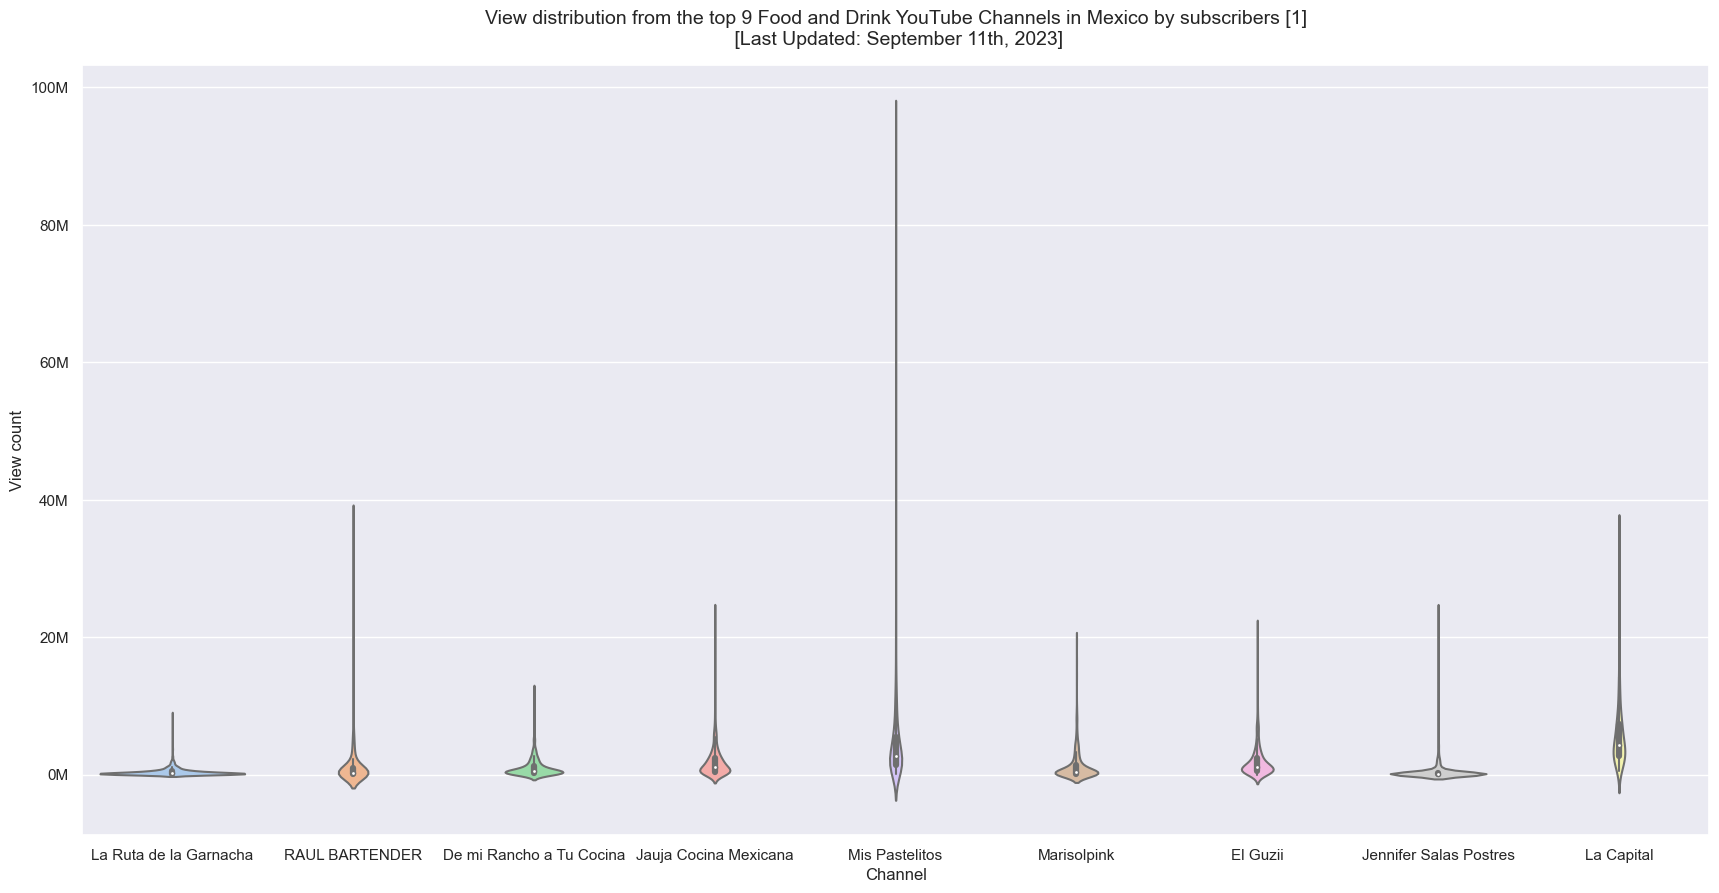

In [73]:
plt.rcParams['figure.figsize'] = (21, 10)
ax= sns.violinplot(x= video_df['channel_title'], y= video_df['view_count'], palette = 'pastel')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1_000_000) + 'M'))

ax.set_xlabel('Channel')
ax.set_ylabel('View count')
plt.title("View distribution from the top 9 Food and Drink YouTube Channels in Mexico by subscribers [1]\n [Last Updated: September 11th, 2023]", fontsize = 14, pad= 15);

### Views vs likes and comments

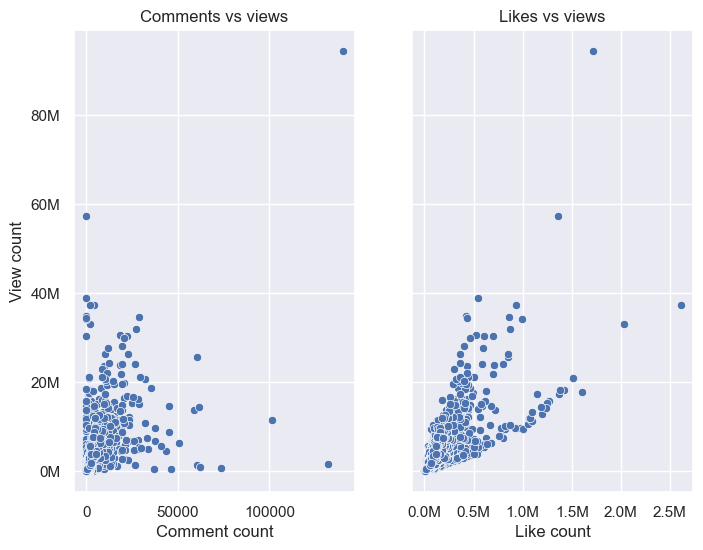

In [74]:
fig, ax = plt.subplots(1,2, figsize=(8, 6), sharey=True)

sns.scatterplot(data = video_df, x = 'comment_count', y = 'view_count', ax = ax[0])
sns.scatterplot(data = video_df, x = 'like_count', y = 'view_count', ax = ax[1])

ax[0].set(xlabel='Comment count', ylabel='View count', title='Comments vs views')
ax[1].set(xlabel='Like count', ylabel='View count', title='Likes vs views')

ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.1f}'.format(x/1_000_000) + 'M'))
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1_000_000) + 'M'));

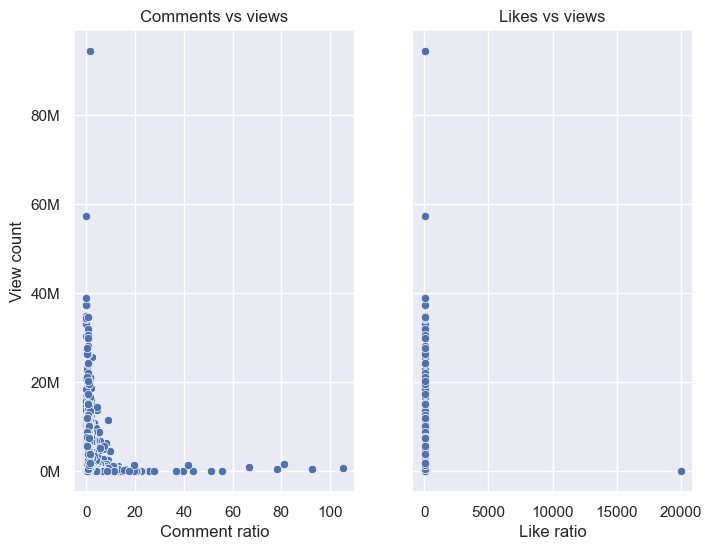

In [75]:
fig, ax = plt.subplots(1,2, figsize=(8, 6), sharey=True)

sns.scatterplot(data = video_df, x = 'comment_ratio', y = 'view_count', ax = ax[0])
sns.scatterplot(data = video_df, x = 'like_ratio', y = 'view_count', ax = ax[1])

ax[0].set(xlabel='Comment ratio', ylabel='View count', title='Comments vs views')
ax[1].set(xlabel='Like ratio', ylabel='View count', title='Likes vs views')

ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1_000_000) + 'M'));

In [76]:
video_df[video_df['like_ratio'] > 10_000]

,video_id,channel_title,title,description,tags,published_at,view_count,like_count,favorite_count,comment_count,duration,definition,caption,published_day_name,duration_secs,tag_count,like_ratio,comment_ratio,title_length
3662,wbSnL788Aus,Marisolpink,●EN VIVO● Marisolpink Pollo al vinoblanco y CH...,Hoy vamos a cocinar un pollo en crema de vino ...,None,2023-05-05 01:58:57+00:00,0.0,18.0,NaN,0.0,P0D,sd,false,Friday,0.0,0,inf,NaN,77
4570,sXxbEUYuJ0Q,El Guzii,El Guzii Live Stream,,None,2017-03-10 09:14:30+00:00,1.0,20.0,NaN,0.0,P0D,sd,false,Friday,0.0,0,20000.0,0.0,20
5467,W0aILvM_CSs,Jennifer Salas Postres,Transmisión en directo de Jennifer Salas Postres,,None,2019-04-10 00:25:59+00:00,0.0,2.0,NaN,0.0,P0D,sd,false,Wednesday,0.0,0,inf,NaN,48


In [77]:
drop_rows = video_df[video_df['like_ratio'] > 10_000].index

video_df = video_df.drop(drop_rows, axis=0)

video_df = video_df.reset_index(drop=True)

video_df


,video_id,channel_title,title,description,tags,published_at,view_count,like_count,favorite_count,comment_count,duration,definition,caption,published_day_name,duration_secs,tag_count,like_ratio,comment_ratio,title_length
0,U_u_duq11QI,La Ruta de la Garnacha,Increible y jugoso LECHÓN HORNEADO en la Narvarte,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-12 14:00:29+00:00,7566.0,595.0,NaN,6.0,PT58S,hd,false,Tuesday,58.0,47,78.641290,0.793021,49
1,i3pGylK847s,La Ruta de la Garnacha,¿TORTAS ó TACOS? 24HRS de SABOR en Ferrería,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-11 18:33:45+00:00,209993.0,5444.0,NaN,209.0,PT15M34S,hd,false,Monday,934.0,54,25.924674,0.995271,43
2,kOLRh9e9XiM,La Ruta de la Garnacha,Las FAMOSAS y AUTÉNTICAS Flautas de La Romero ...,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-10 16:00:36+00:00,13241.0,894.0,NaN,13.0,PT1M,hd,false,Sunday,60.0,47,67.517559,0.981799,51
3,aPkvpghF2tY,La Ruta de la Garnacha,Super TACOS de CARNITAS con mucho sabor a Mich...,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-09 16:30:01+00:00,19216.0,1246.0,NaN,9.0,PT58S,hd,false,Saturday,58.0,47,64.841799,0.468360,51
4,jbyl5Mq2sk0,La Ruta de la Garnacha,FLAUTAS SÚPER rellenas de CARNE,"⬇⬇⬇⬇UBICACIÓN, HORARIOS Y COSTO DEL LUGAR ⬇⬇⬇⬇...","[Yo, soy, migue, el, papa, de, Lalo, villar, l...",2023-09-08 14:00:25+00:00,11086.0,806.0,NaN,12.0,PT51S,hd,false,Friday,51.0,47,72.704312,1.082446,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6016,qQ1P2JPf_IU,La Capital,Queso fundido con Chorizo | Botana Fácil | La ...,Gran opción para botanear antes de una carne a...,"[queso fundido, queso gratinado, con chorizo, ...",2016-08-27 16:30:01+00:00,3778484.0,155069.0,NaN,3020.0,PT7M9S,hd,false,Saturday,429.0,25,41.040004,0.799262,53
6017,VcciYKH8hAM,La Capital,Verdaderos Camarones A LA DIABLA | La Capital,Después de varias malas experiencias en restau...,"[camarones a la diabla, camarones, mexican sea...",2016-08-21 16:30:00+00:00,3851719.0,122541.0,NaN,2705.0,PT5M56S,hd,false,Sunday,356.0,19,31.814626,0.702284,45
6018,0uDlaSepHL0,La Capital,Chilaquiles Verdes con Huevo | La Capital,El mejor desayuno y mi favorito siempre! Chila...,"[chilaquiles, chilaquiles verdes, chile habane...",2016-08-14 16:45:04+00:00,3881171.0,122292.0,NaN,5156.0,PT9M55S,hd,false,Sunday,595.0,13,31.509047,1.328465,41
6019,TtaybghWcow,La Capital,Pechuga Rellena de Camaron *ENVUELTA EN TOCINO...,Video de Aguachiles: https://goo.gl/nsRHPd\n\n...,"[pechuga de pollo, pechuga rellena, camarones,...",2016-08-10 14:51:50+00:00,1759061.0,70956.0,NaN,2708.0,PT12M36S,hd,false,Wednesday,756.0,19,40.337430,1.539458,83


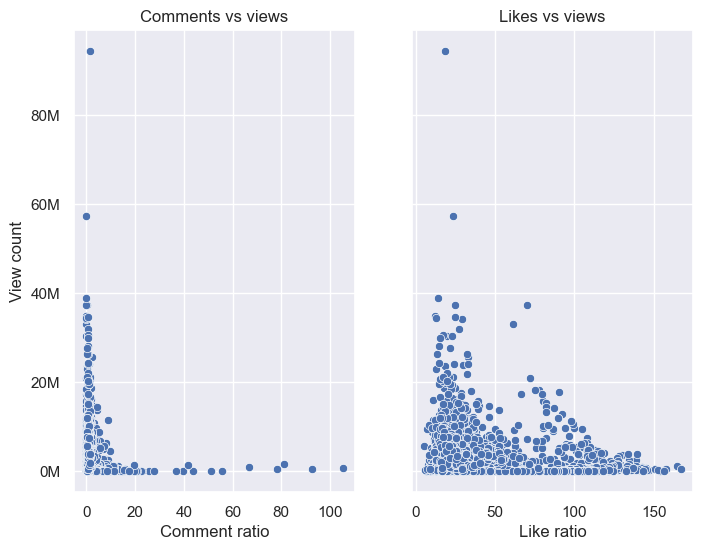

In [78]:
fig, ax = plt.subplots(1,2, figsize=(8, 6), sharey=True)

sns.scatterplot(data = video_df, x = 'comment_ratio', y = 'view_count', ax = ax[0])
sns.scatterplot(data = video_df, x = 'like_ratio', y = 'view_count', ax = ax[1])

ax[0].set(xlabel='Comment ratio', ylabel='View count', title='Comments vs views')
ax[1].set(xlabel='Like ratio', ylabel='View count', title='Likes vs views')

ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1_000_000) + 'M'));

### The impact of video length on views, likes and comments

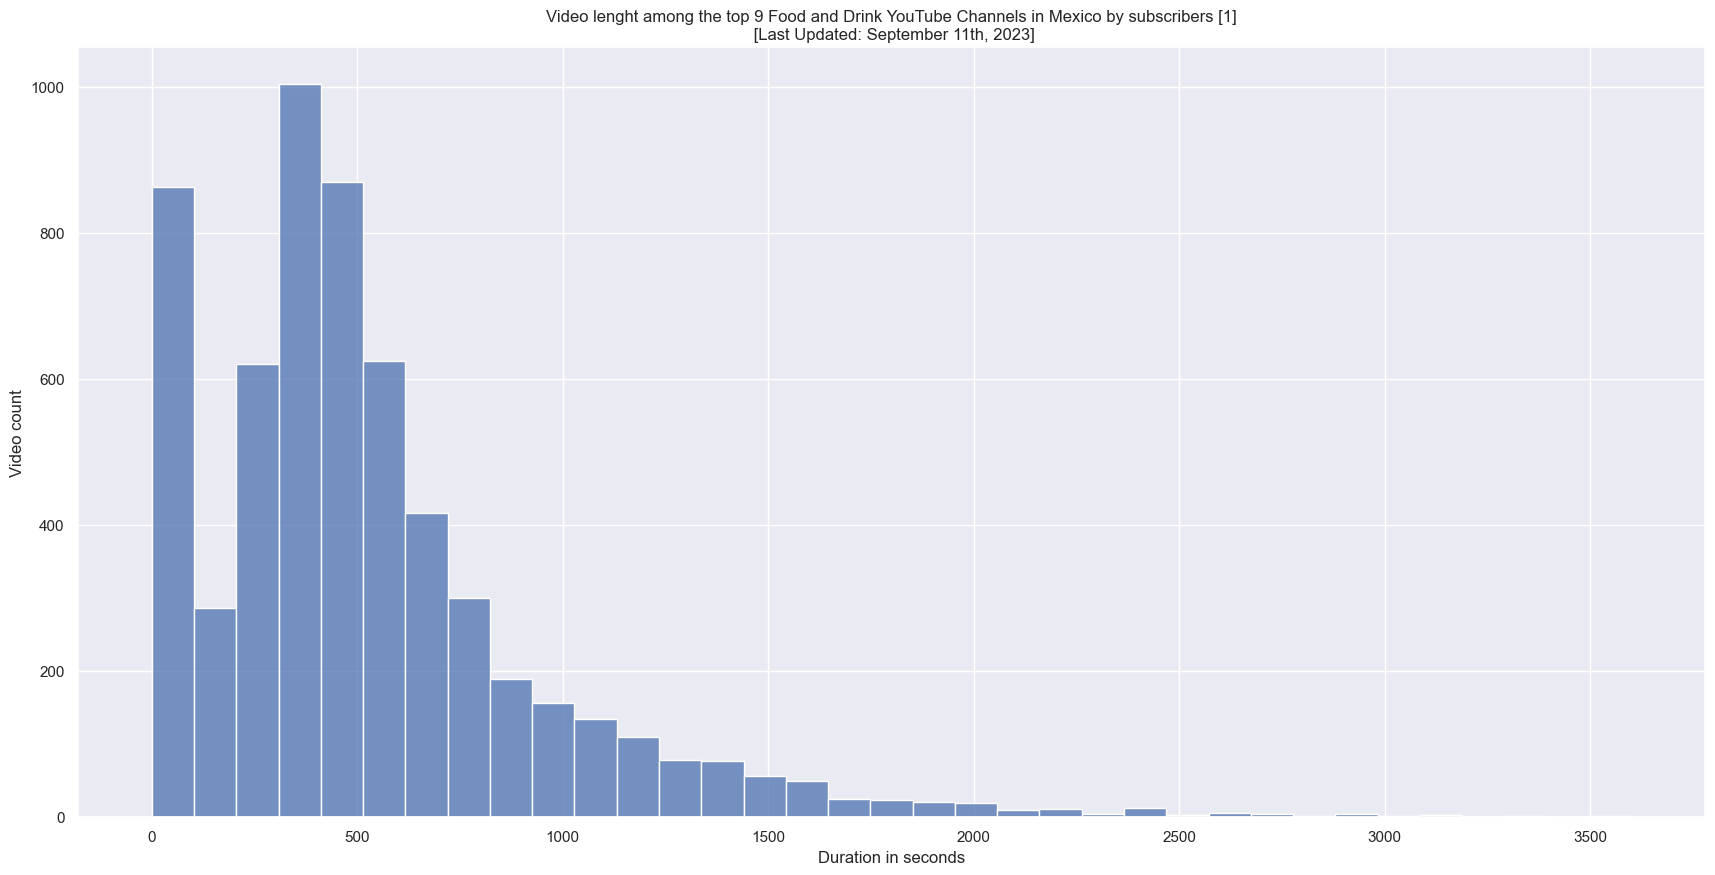

In [79]:
ax= sns.histplot(data=video_df[video_df['duration_secs'] < 10000], x="duration_secs", bins=35, binrange=(0, 3_600))

ax.set(xlabel='Duration in seconds', ylabel='Video count', title='Video lenght among the top 9 Food and Drink YouTube Channels in Mexico by subscribers [1]\n [Last Updated: September 11th, 2023]');

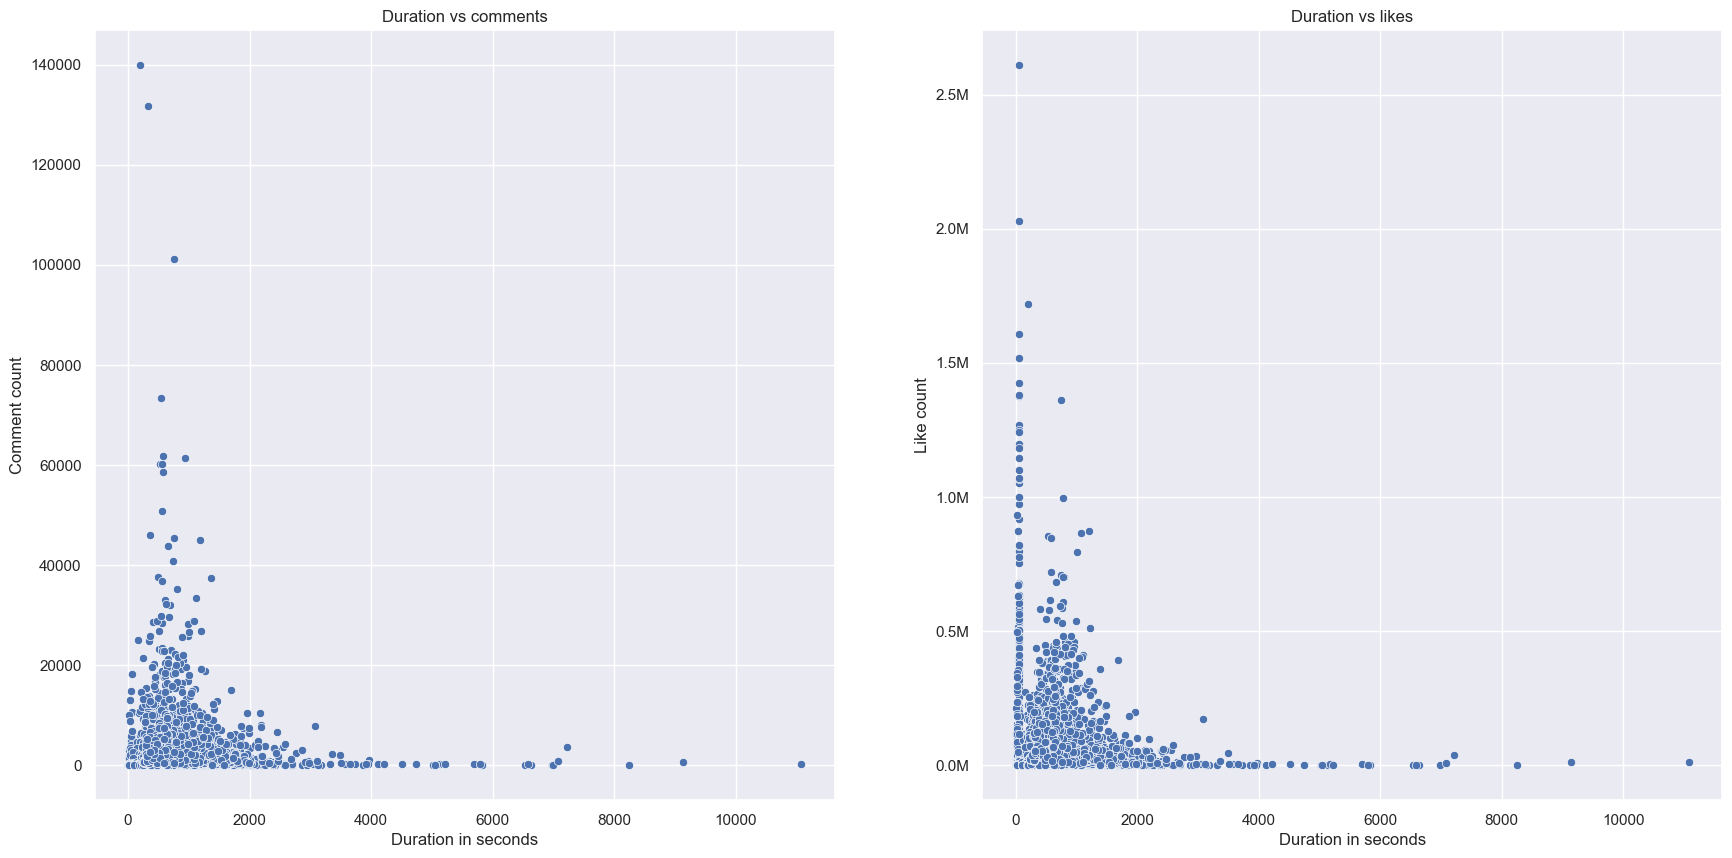

In [80]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "duration_secs", y = "comment_count", ax=ax[0])
sns.scatterplot(data = video_df, x = "duration_secs", y = "like_count", ax=ax[1])

ax[0].set(xlabel='Duration in seconds', ylabel='Comment count', title='Duration vs comments')
ax[1].set(xlabel='Duration in seconds', ylabel='Like count', title='Duration vs likes')

ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.1f}'.format(x/1_000_000) + 'M'));

# Title lenght vs views

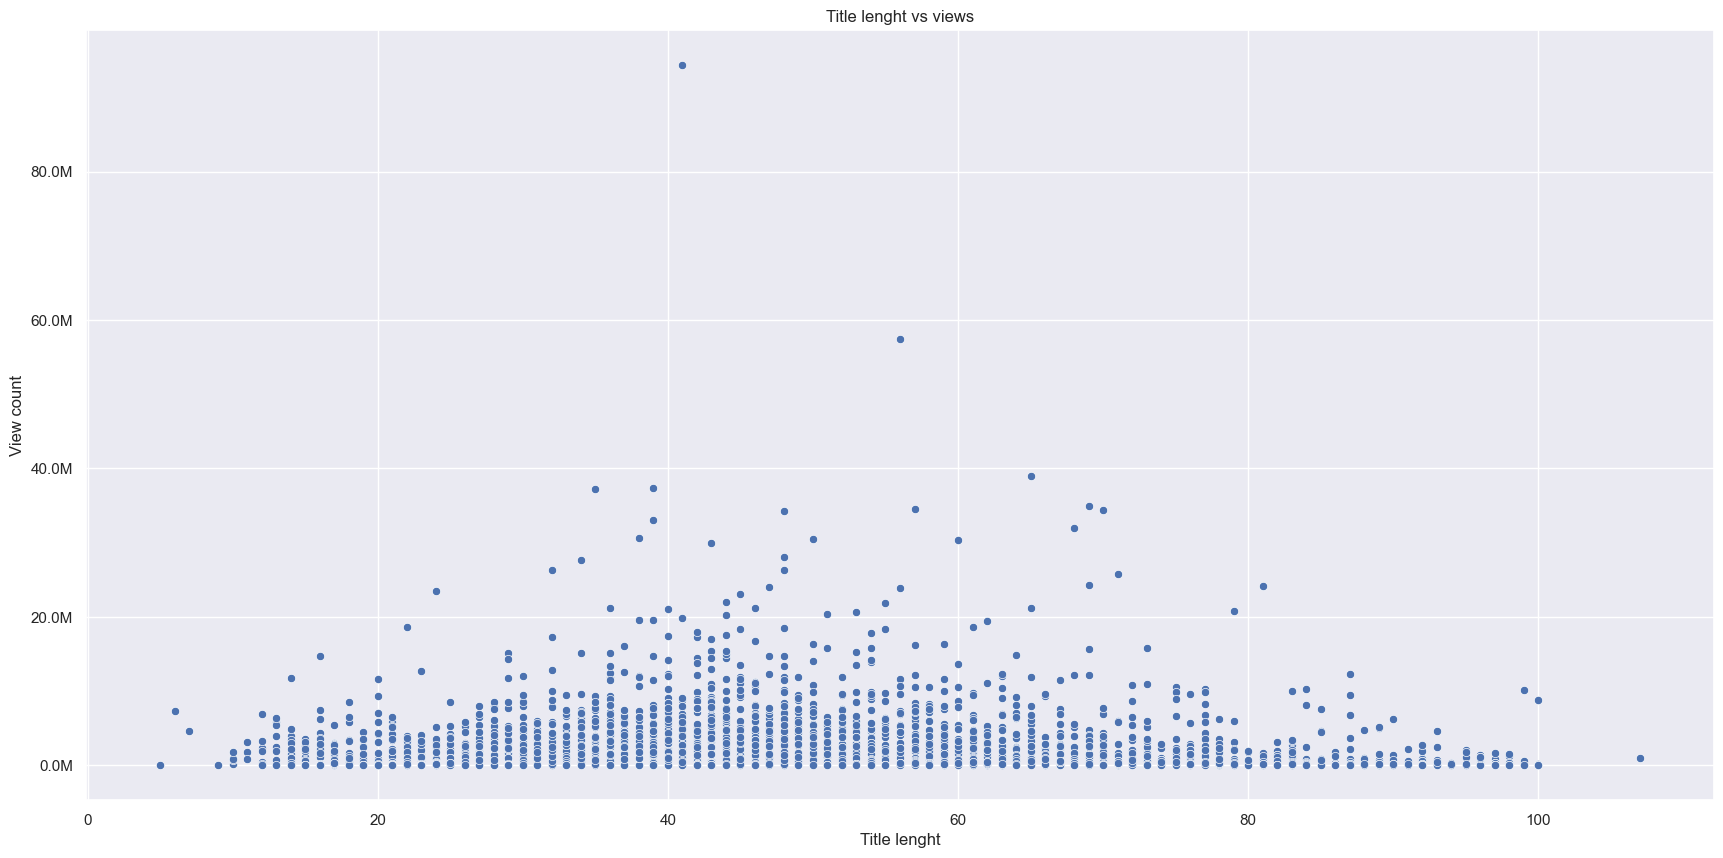

In [81]:
ax = sns.scatterplot(data = video_df, x = "title_length", y = "view_count")

ax.set(xlabel= 'Title lenght', ylabel= 'View count', title='Title lenght vs views')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.1f}'.format(x/1_000_000) + 'M'));

### Word cloud for video titles

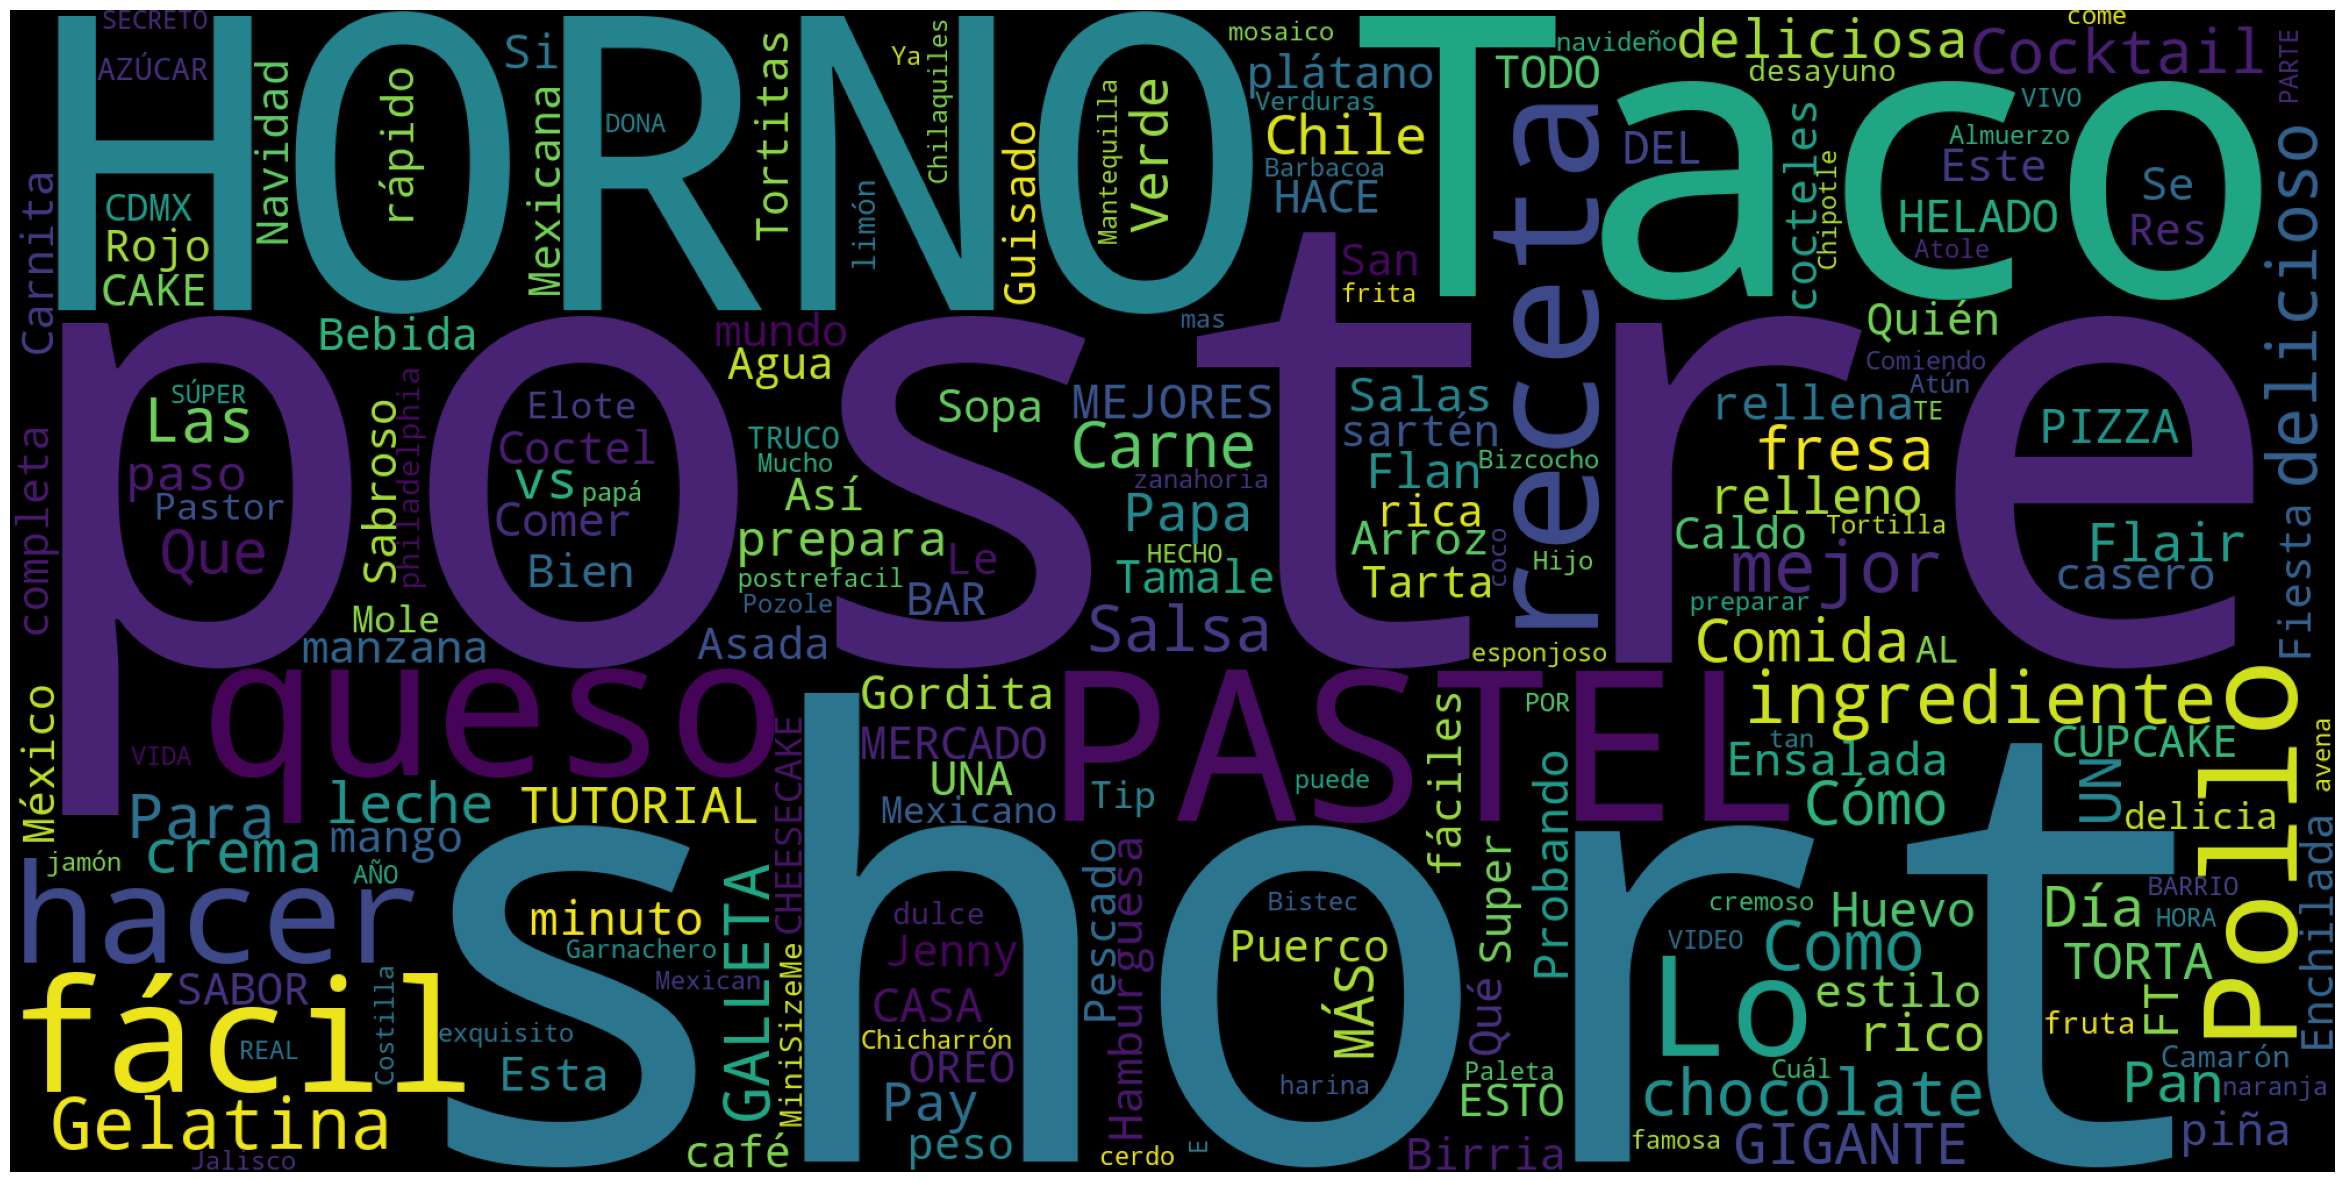

In [82]:
# Define your custom Spanish stopwords
custom_spanish_stopwords = set([
    'Mi',
    'Mis',
    'De',
    'El',
    'Guzii',
    'Marisolpink',
    'Pastelito',
    'Pastelitos',
    'Bartender',
    'Cocina',
    'La',
    'Capital',
    'En',
    'Rancho',
    'Tu',
    'Garnacha',
    'DondeiniciaMexicoLRG',
    'Sin',
    'Con',
    'Y',
    'Solo',
    'Muy'
    # Add more stopwords as needed
])

# Combine your custom stopwords with any existing stopwords you want to include
all_spanish_stopwords = custom_spanish_stopwords.union(set(STOPWORDS))

# Generate the WordCloud using the custom Spanish stopwords
wordcloud = WordCloud(
    width=2000,
    height=1000,
    random_state=1,
    background_color='black',
    colormap='viridis',
    collocations=False,
    stopwords=all_spanish_stopwords  # Use the custom Spanish stopwords
).generate(all_words_str)

plot_cloud(wordcloud)


# Number of tags vs views

In [ ]:
ax = sns.scatterplot(data = video_df, x = "title_length", y = "view_count")

ax.set(xlabel= 'Title lenght', ylabel= 'View count', title='Title lenght vs views')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.1f}'.format(x/1_000_000) + 'M'));

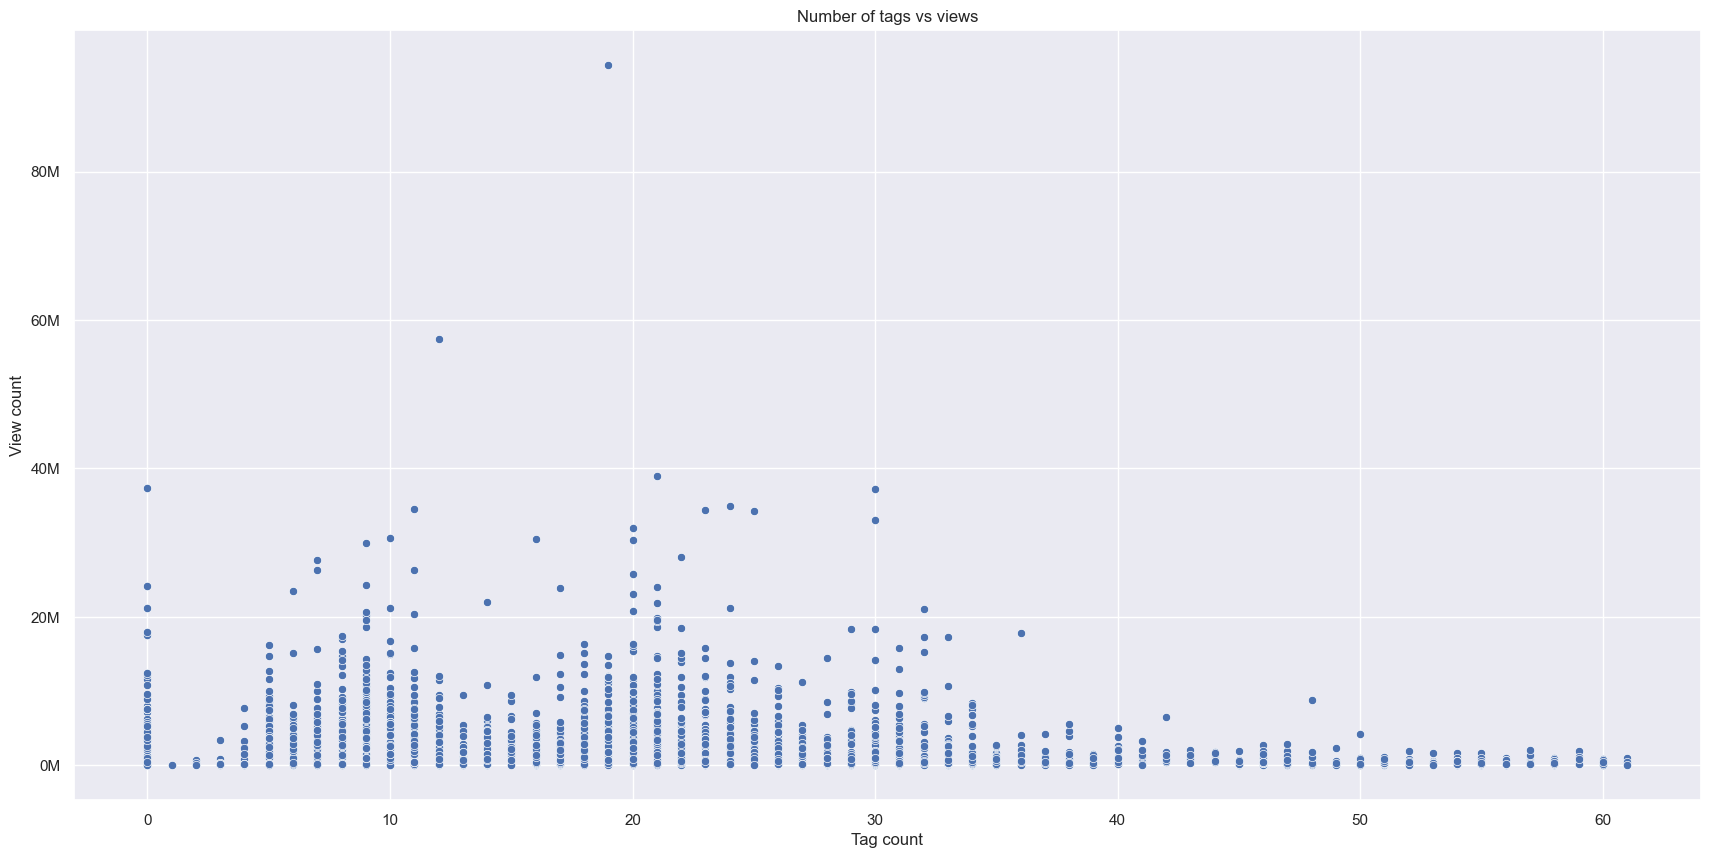

In [89]:
ax = sns.scatterplot(data = video_df, x = 'tag_count', y = 'view_count')

ax.set(xlabel= 'Tag count', ylabel= 'View count', title='Number of tags vs views')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1_000_000) + 'M'));

### Update schedule

In [ ]:
# Count quantity of videos and divide by weekday
day_df = pd.DataFrame(video_df['published_day_name'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)

# Actual plot
ax = sns.barplot(x = 'index', y = 'published_day_name', data = day_df.reset_index())

plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

ax.set_xlabel('Weekday')
ax.set_ylabel('Video count')
plt.title('Update schedule \n [Last Updated: September 9th, 2023]', pad= 15);

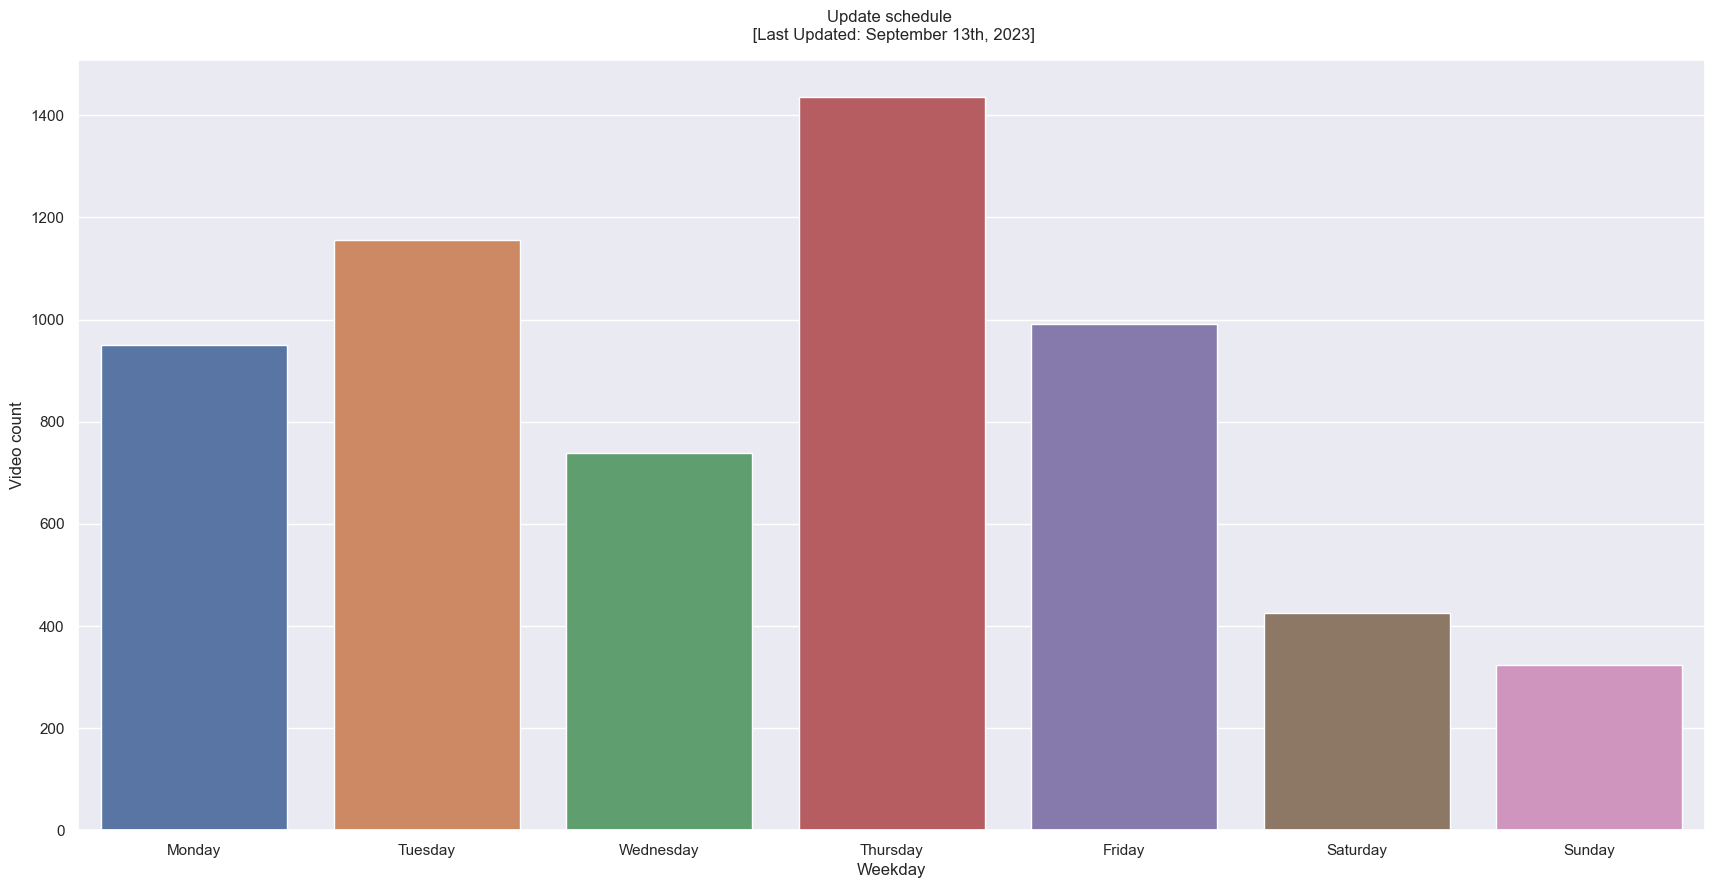

In [91]:
day_df = pd.DataFrame(video_df['published_day_name'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)

# Actual plot
ax = sns.barplot(x = 'index', y = 'published_day_name', data = day_df.reset_index())

plot = ax.set_xticklabels(ax.get_xticklabels())

ax.set_xlabel('Weekday')
ax.set_ylabel('Video count')
plt.title('Update schedule \n [Last Updated: September 13th, 2023]', pad= 15);

# Resources:
[1] Top 1000 Food and Drink YouTube Channels in Mexico. https://hypeauditor.com/es/top-youtube-food-drinks-mexico/
